## **BootCamp de Machine Learning**

Desafio do curso de Inteligencia Artificial e Machine Learning da FIAP visando desenvolver uma solução para uma empresa de suprimentos onde a análise de crédito passaria a ser totalmente automatizada no momento da solicitação/pedido

## Lógica usada neste trabalho
Existem alguns desafios principais neste dataset:
* Possui muitos nulos
* Algumas variáveis não são 'inputáveis' por virem de outros setores da empresa
* Alta correlação entre colunas. Portanto, será necessário realizar uma redução de dimensionalidade e tratamento dos dados, primeiramente em colunas que indicam informações que passaram por outros setores da empresa, de forma a permitir um retorno automatizado.

## Análise Exploratória

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import legend
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import json

from scipy import stats
import warnings

import pickle

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/GlauOrla/Bootcamp_Fiap/main/bootcamp-solicitacoescredito.csv')

In [6]:
df.shape

(8973, 38)

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973 entries, 0 to 8972
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           8973 non-null   int64  
 1   razaoSocial                  8973 non-null   object 
 2   nomeFantasia                 8973 non-null   object 
 3   cnpjSemTraco                 8973 non-null   object 
 4   maiorAtraso                  8973 non-null   int64  
 5   margemBrutaAcumulada         8973 non-null   float64
 6   percentualProtestos          7475 non-null   float64
 7   primeiraCompra               8867 non-null   object 
 8   prazoMedioRecebimentoVendas  8973 non-null   int64  
 9   titulosEmAberto              8973 non-null   float64
 10  valorSolicitado              8973 non-null   float64
 11  status                       8973 non-null   object 
 12  definicaoRisco               8973 non-null   object 
 13  diferencaPercentua

In [8]:
# Verificando a quantidade de valores únicos
df.nunique()

numero_solicitacao             8973
razaoSocial                    2759
nomeFantasia                   2677
cnpjSemTraco                   2829
maiorAtraso                     175
margemBrutaAcumulada           2145
percentualProtestos              10
primeiraCompra                 1950
prazoMedioRecebimentoVendas     180
titulosEmAberto                 761
valorSolicitado                 363
status                            7
definicaoRisco                    4
diferencaPercentualRisco         79
percentualRisco                  81
dashboardCorrelacao             701
valorAprovado                   326
dataAprovadoEmComite            558
periodoBalanco                  124
ativoCirculante                1794
passivoCirculante              1789
totalAtivo                     1788
totalPatrimonioLiquido         1759
endividamento                  1185
duplicatasAReceber             1668
estoque                        1674
faturamentoBruto               4288
margemBruta                 

In [9]:
# Identificando a quantidade de valores nulos
df.isnull().sum()

numero_solicitacao                0
razaoSocial                       0
nomeFantasia                      0
cnpjSemTraco                      0
maiorAtraso                       0
margemBrutaAcumulada              0
percentualProtestos            1498
primeiraCompra                  106
prazoMedioRecebimentoVendas       0
titulosEmAberto                   0
valorSolicitado                   0
status                            0
definicaoRisco                    0
diferencaPercentualRisco          0
percentualRisco                   0
dashboardCorrelacao               0
valorAprovado                  1404
dataAprovadoEmComite           8415
periodoBalanco                 4240
ativoCirculante                4240
passivoCirculante              4240
totalAtivo                     4240
totalPatrimonioLiquido         4240
endividamento                  4240
duplicatasAReceber             4240
estoque                        4240
faturamentoBruto                750
margemBruta                 

###Distribuição dos dados entre as variáveis independentes (features) e dependente (target)

In [10]:
# Função para gerar gráficos stripplot
# param1: nome do dataframe
# param2: variável do eixo X
# param3: variável do eixo Y
# param4: axis
# param5: label para gráfico
# param6: paleta de cores, default: Set2

def graf_stripplot(param1, param2, param3, param4, param5, param6='Set2'):
    sns.stripplot(data=param1, x=param2, y=param3,
                  ax=param4, hue=param2, palette=param6)
    param4.set_xlabel('')
    param4.set_ylabel('')
    param4.tick_params(labelsize=10)
    param4.yaxis.set_major_formatter(mtick.ScalarFormatter())
    param4.ticklabel_format(style='plain', axis='y')
    param4.set_title(param5, loc='right', fontsize=12)
    param4.legend()
    param4.set_xticklabels([])

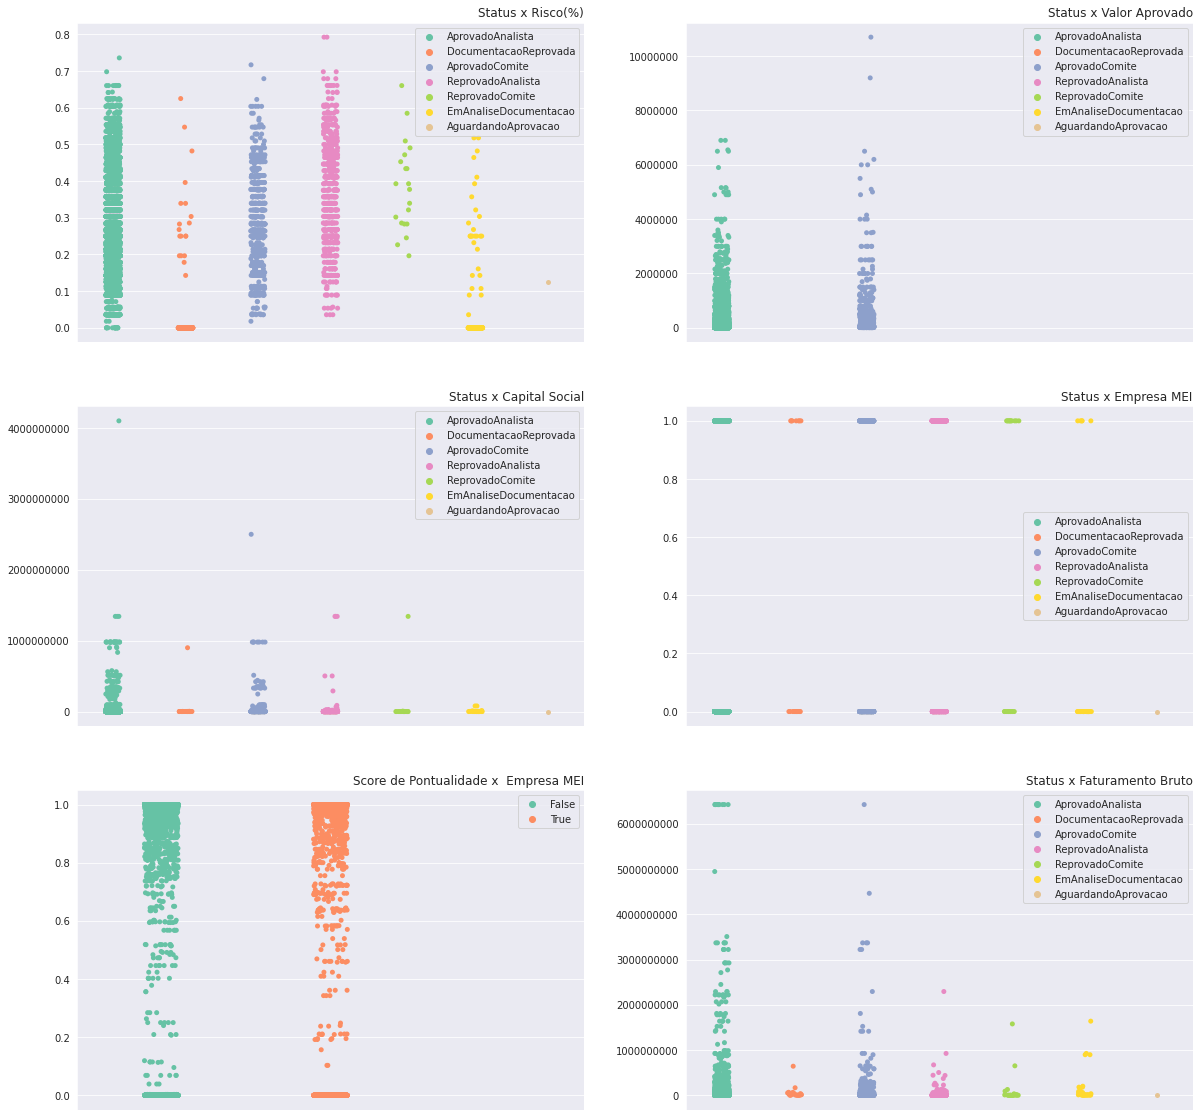

In [11]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

graf_stripplot(df, 'status', 'percentualRisco', ax1,
                 'Status x Risco(%)')
graf_stripplot(df, 'status', 'valorAprovado', ax2,
                 'Status x Valor Aprovado')
graf_stripplot(df, 'status', 'capitalSocial', ax3,
                 'Status x Capital Social')
graf_stripplot(df, 'status', 'empresa_MeEppMei', ax4,
                 'Status x Empresa MEI')
graf_stripplot(df, 'empresa_MeEppMei', 'scorePontualidade',
                 ax5, 'Score de Pontualidade x  Empresa MEI')
graf_stripplot(df, 'status', 'faturamentoBruto', ax6,
                 'Status x Faturamento Bruto')

plt.show()

## Normalizando as colunas

In [12]:
#Porcentagem de NaNs nas variáveis:
percent_missing = df.isna().sum()/df.shape[0] * 100
percent_missing = percent_missing.apply(lambda x: f"{x:.2f}%")
percent_missing = percent_missing.sort_values(ascending=False)
print(percent_missing)

dataAprovadoEmComite           93.78%
periodoDemonstrativoEmMeses     8.36%
custos                          8.36%
margemBruta                     8.36%
faturamentoBruto                8.36%
limiteEmpresaAnaliseCredito     8.30%
empresa_MeEppMei                8.30%
restricoes                      8.30%
capitalSocial                   8.30%
intervaloFundacao               8.30%
anoFundacao                     8.30%
endividamento                  47.25%
totalAtivo                     47.25%
totalPatrimonioLiquido         47.25%
ativoCirculante                47.25%
duplicatasAReceber             47.25%
estoque                        47.25%
passivoCirculante              47.25%
periodoBalanco                 47.25%
dataAprovadoNivelAnalista      21.87%
percentualProtestos            16.69%
valorAprovado                  15.65%
primeiraCompra                  1.18%
razaoSocial                     0.00%
nomeFantasia                    0.00%
scorePontualidade               0.00%
cnpjSemTraco

In [13]:
cnpj_empresas = df['cnpjSemTraco'].unique()
print(str(len(cnpj_empresas))+' diferentes empresas no dataset')
print(str(df.shape[0])+' total de solicitações')

2829 diferentes empresas no dataset
8973 total de solicitações


In [14]:
contagem_cnpj = df['cnpjSemTraco'].value_counts()
contagem_cnpj 

AVAO63044598911311    25
GTPO06511661214973    21
JXCH36268697453955    21
SPID07567212738639    20
VVSW90409251685348    20
                      ..
FFDA30162346840261     1
FZAM67912003013290     1
VKWY52712649875504     1
QCSZ76425273477324     1
IPFS70635894073808     1
Name: cnpjSemTraco, Length: 2829, dtype: int64

In [15]:
cadastro_11311 = df.loc[df['cnpjSemTraco']=='AVAO63044598911311']
print(str(cadastro_11311.shape[0])+' solicitações do cnpj AVAO63044598911311')
cadastro_11311.head()

25 solicitações do cnpj AVAO63044598911311


,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
964,992,Suzanne Smith,Marian Day,AVAO63044598911311,14,0.565046,0.0,2019-12-17T00:00:00,42,118195.87,...,9.0,65353601.0,2004.0,De 11 a 16 anos,3000000.0,False,True,1.0,7728528.0,NaN
1187,1222,Suzanne Smith,Marian Day,AVAO63044598911311,14,0.565046,0.0,2019-12-17T00:00:00,42,118195.87,...,9.0,65353601.0,2004.0,De 11 a 16 anos,3000000.0,False,True,1.0,7728528.0,2020-03-16T17:32:46
2315,2388,Suzanne Smith,Marian Day,AVAO63044598911311,14,0.565046,0.0,2019-12-17T00:00:00,42,118195.87,...,12.0,87230284.0,2004.0,De 11 a 16 anos,3000000.0,False,True,1.0,7728528.0,2020-05-28T15:41:51
2819,2892,Suzanne Smith,Marian Day,AVAO63044598911311,14,0.565046,0.0,2019-12-17T00:00:00,42,118195.87,...,12.0,87230284.0,2004.0,De 11 a 16 anos,3000000.0,False,True,1.0,6480000.0,2020-06-26T17:50:48
3083,3156,Suzanne Smith,Marian Day,AVAO63044598911311,14,0.565046,0.0,2019-12-17T00:00:00,42,118195.87,...,12.0,87230284.0,2004.0,De 11 a 16 anos,3000000.0,False,True,1.0,6480000.0,2020-07-09T20:47:57


In [16]:
# função para preencher linhas de variáveis do mesmo CNPJ e que possuem o mesmo significado
def fill_missing_values(df, col_conditional):
  for idx, row in df.iterrows():
    if row.isna().any():
      matches = df[df[col_conditional] == row[col_conditional]]
      modes = matches.dropna().mode()
      if not modes.empty:
        modes = modes.iloc[0]
        for col in df.columns:
          if col not in ["valorAprovado", "dataAprovadoNivelAnalista"] and pd.isna(row[col]):
            col_idx = df.columns.get_loc(col)
            df.loc[idx, col] = modes[col_idx]
  return df

In [17]:
# Aplicando a função
fill_missing_values(df, 'cnpjSemTraco')

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.000000,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.000000,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,...,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.000000,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.000000,89000.0,2020-02-04T15:06:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,9041,Leah Williams,Georgia Booth,YKGZ02907098931653,149,0.306580,0.0,2006-04-26T00:00:00,59,599964.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990876,NaN,NaN
8969,9042,Mr. Jordan Stevens,Miss Ellie Kelly,UCBM91111020900951,23,0.329796,0.0,2016-08-03T00:00:00,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958869,NaN,NaN
8970,9043,Mr. Barry Wells,Danielle Hudson,CLDB61185288622179,3,0.383919,0.0,2018-10-25T00:00:00,4,2933.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
8971,9044,Keith Jones,Steven Kennedy-Jones,BRJP37453437154592,11,0.424099,0.0,2011-08-10T00:00:00,31,559679.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994786,NaN,NaN


In [18]:
#Checando
percent_missing = df.isna().sum()/df.shape[0] * 100
percent_missing = percent_missing.apply(lambda x: f"{x:.2f}%")
percent_missing = percent_missing.sort_values(ascending=False)
print(percent_missing)

dataAprovadoEmComite           93.78%
periodoDemonstrativoEmMeses     8.36%
custos                          8.36%
margemBruta                     8.36%
faturamentoBruto                8.36%
limiteEmpresaAnaliseCredito     8.30%
empresa_MeEppMei                8.30%
restricoes                      8.30%
capitalSocial                   8.30%
intervaloFundacao               8.30%
anoFundacao                     8.30%
endividamento                  47.25%
totalAtivo                     47.25%
totalPatrimonioLiquido         47.25%
ativoCirculante                47.25%
duplicatasAReceber             47.25%
estoque                        47.25%
passivoCirculante              47.25%
periodoBalanco                 47.25%
dataAprovadoNivelAnalista      21.87%
percentualProtestos            16.69%
valorAprovado                  15.65%
primeiraCompra                  1.18%
razaoSocial                     0.00%
nomeFantasia                    0.00%
scorePontualidade               0.00%
cnpjSemTraco

# **Dimensionalidade e Correlação**
Verificando a possibilidade de remover colunas com alta correlação e que não atendem à necessidade de propor valor de crédito de forma automatizada, e assim reduzir o dataset.

## Mapeando Correlações

ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;

ρ = 0,7 a 09 (positivo ou negativo): correlação forte;

ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;

ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;

ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.

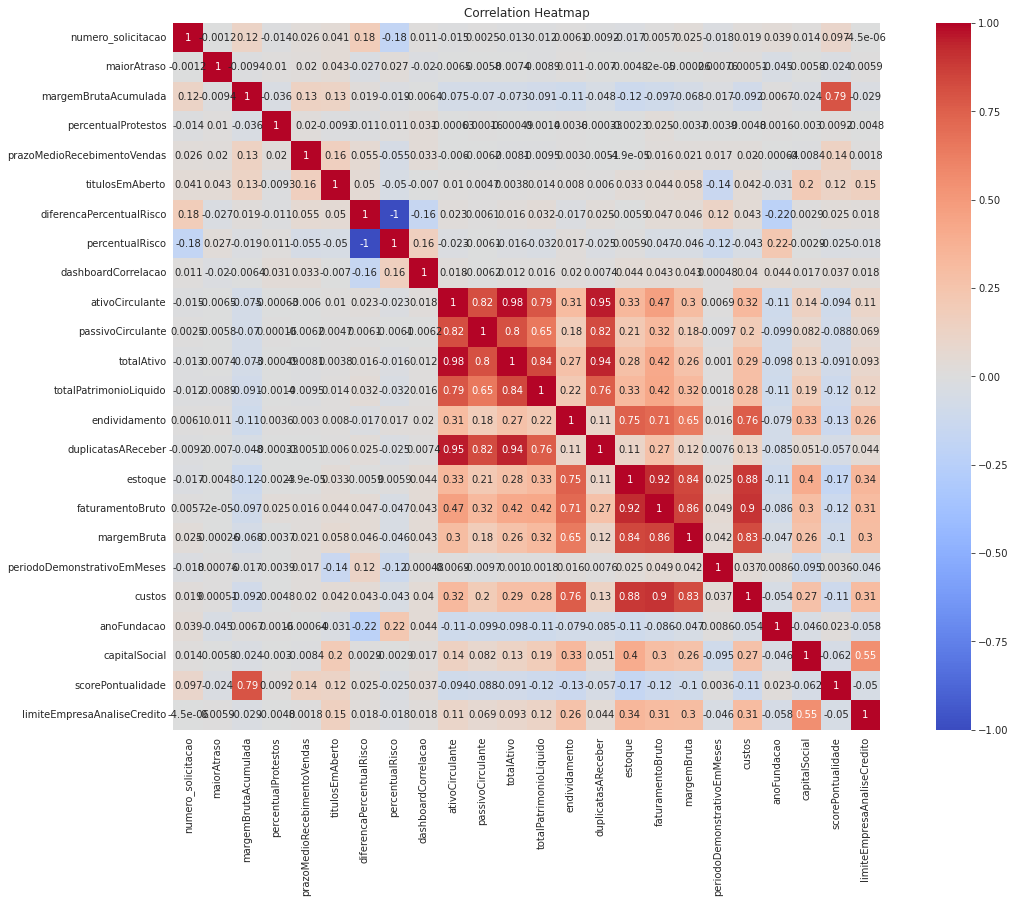

In [19]:
def verifica_correlacao(df):
    corr_matrix = df.drop(columns=['valorSolicitado','valorAprovado']).corr() 
    plt.figure(figsize=(20, 13))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Heatmap')
    plt.show()
    return corr_matrix
corr_matrix = verifica_correlacao(df)

Nota-se acima a alta correlação entre muitas variáveis. Desse modo, o código a seguir busca otimizar a visualização das variáveis e suas maiores correlações

In [20]:
colunas_alta_correlacao = {}
for row_idx, row in corr_matrix.iterrows():
    dict_row = {}
    for col in corr_matrix.columns:
        if col != row_idx:
            dict_row.update({row[col]:col})
    score_correlacao_ascendente = []
    for corr_score in sorted(dict_row, reverse=True):
        score_correlacao_ascendente.append(dict_row[corr_score])
    colunas_alta_correlacao.update({row_idx:score_correlacao_ascendente})
df_correlacao_ordenada = pd.DataFrame.from_dict(colunas_alta_correlacao).T
df_correlacao_ordenada = df_correlacao_ordenada[[0,1,2]]
df_correlacao_ordenada.sort_index(inplace=True)
df_correlacao_ordenada.columns = ['maior', 'segunda_maior', 'terceira_maior']
df_correlacao_ordenada

,maior,segunda_maior,terceira_maior
anoFundacao,percentualRisco,dashboardCorrelacao,numero_solicitacao
ativoCirculante,totalAtivo,duplicatasAReceber,passivoCirculante
capitalSocial,limiteEmpresaAnaliseCredito,estoque,endividamento
custos,faturamentoBruto,estoque,margemBruta
dashboardCorrelacao,percentualRisco,estoque,anoFundacao
diferencaPercentualRisco,numero_solicitacao,periodoDemonstrativoEmMeses,prazoMedioRecebimentoVendas
duplicatasAReceber,ativoCirculante,totalAtivo,passivoCirculante
endividamento,custos,estoque,faturamentoBruto
estoque,faturamentoBruto,custos,margemBruta
faturamentoBruto,estoque,custos,margemBruta


In [21]:
corr_matrix.head()

,numero_solicitacao,maiorAtraso,margemBrutaAcumulada,percentualProtestos,prazoMedioRecebimentoVendas,titulosEmAberto,diferencaPercentualRisco,percentualRisco,dashboardCorrelacao,ativoCirculante,...,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,periodoDemonstrativoEmMeses,custos,anoFundacao,capitalSocial,scorePontualidade,limiteEmpresaAnaliseCredito
numero_solicitacao,1.000000,-0.001187,0.121658,-0.013972,0.025867,0.040793,0.182817,-0.182817,0.010810,-0.014591,...,-0.009196,-0.017464,0.005654,0.024875,-0.018438,0.019459,0.039041,0.013688,0.096835,-0.000004
maiorAtraso,-0.001187,1.000000,-0.009411,0.009961,0.019811,0.042529,-0.027167,0.027167,-0.020068,-0.006541,...,-0.006979,-0.004794,-0.000020,-0.000261,0.000763,0.000508,-0.045360,-0.005795,-0.024385,0.005947
margemBrutaAcumulada,0.121658,-0.009411,1.000000,-0.036410,0.134852,0.131089,0.018646,-0.018646,-0.006405,-0.075105,...,-0.047640,-0.124929,-0.097173,-0.068280,-0.017121,-0.091654,0.006705,-0.023858,0.792421,-0.028724
percentualProtestos,-0.013972,0.009961,-0.036410,1.000000,0.019934,-0.009275,-0.011283,0.011283,0.031373,-0.000627,...,-0.000327,-0.002289,0.024507,-0.003681,-0.003950,-0.004816,0.001600,-0.003025,0.009248,-0.004778
prazoMedioRecebimentoVendas,0.025867,0.019811,0.134852,0.019934,1.000000,0.157219,0.055478,-0.055478,0.033498,-0.005970,...,-0.005060,-0.000049,0.016042,0.020508,0.017217,0.019946,-0.000642,-0.008402,0.139979,0.001829


## Removendo Colunas

Removendo colunas que apresentam alta correlação com outras variáveis ou apresentam significados duplicados

* ativoCirculante - melhor representada pelo totalAtivo
* passivoCirculante - alta correlação com ativoCirculante
* estoque - alta correlação com capitalSocial e faturamentoBruto
* custos - alta correlação com capitalSocial e faturamentoBruto
* duplicatasAReceber - alta correlação com totalAtivo
* totalPatrimonioLiquido - alta correlação com totalAtivo 
* endividamento - alta correlação com faturamentoBruto
* margemBruta - alta correlação com faturamentoBruto
* numero_solicitacao - número de linha = não necessário
* razaoSocial - CNPJ é PK
* nomeFantasia - CNPJ é PK
* maiorAtraso - dado sem referência para novos clientes
* margemBrutaAcumulada - não faz sentido para ML
* percentualProtestos - baseado em dado externo
* status - baseado em dado externo
* definicaoRisco - baseado em dado externo
* diferencaPercentualRisco - baseado em dado externo
* percentualRisco - baseado em dado externo
* dashboardCorrelacao - baseado em dado externo
* dataAprovadoEmComite - baseado em dado externo
* anoFundacao - já existe coluna categórica 'intervaloFundacao' que permitiria segmentacao
* restricoes - baseado em dado externo
* scorePontualidade - baseado em dado externo
* limiteEmpresaAnaliseCredito - baseado em dado externo
* dataAprovadoNivelAnalista - baseado em dado externo
* dataAprovadoNivelAnalista - baseado em dado externo

In [22]:
df_remover = [
            'ativoCirculante',
            'passivoCirculante',
            'estoque',
            'custos',
            'duplicatasAReceber',
            'totalPatrimonioLiquido',
            'endividamento',
            'margemBruta',
            'razaoSocial',
            'nomeFantasia',
            'maiorAtraso',
            'margemBrutaAcumulada',
            'percentualProtestos',
            'status',
            'definicaoRisco',
            'diferencaPercentualRisco',
            'percentualRisco',
            'dashboardCorrelacao',
            'dataAprovadoEmComite',
            'anoFundacao',
            'restricoes',
            'scorePontualidade',
            'limiteEmpresaAnaliseCredito',
            'dataAprovadoNivelAnalista',
            'dataAprovadoNivelAnalista'
            ]

df = df.drop(columns=df_remover)

# Reordenando colunas para target ser a última
df = df[['numero_solicitacao', 'cnpjSemTraco', 'primeiraCompra',
       'prazoMedioRecebimentoVendas', 'titulosEmAberto', 'valorSolicitado',
       'periodoBalanco', 'totalAtivo', 'faturamentoBruto',
       'periodoDemonstrativoEmMeses', 'intervaloFundacao', 'capitalSocial',
       'empresa_MeEppMei','valorAprovado']] 

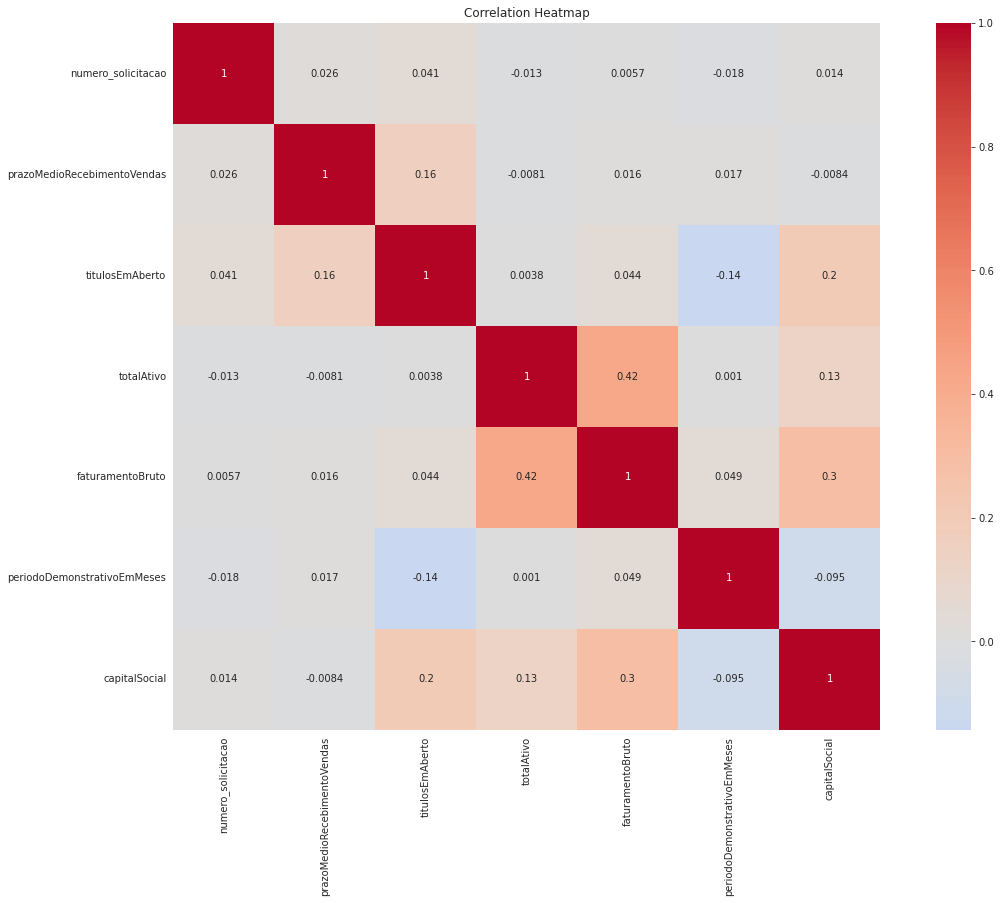

In [23]:
corr_matrix = verifica_correlacao(df)

# **Feature Engineering**

## Tratando dados faltantes

Remover linhas da variavel target que apresentem dados faltantes

In [191]:
df.dropna(subset='valorAprovado', inplace=True)

## Solicitações de crédito

O código abaixo insere uma coluna com quantidades de solicitações de crédito por CNPJ

In [192]:
df["qtd_solic"] = df.groupby('cnpjSemTraco')['cnpjSemTraco'].rank(method="first", ascending=True)
df[['cnpjSemTraco', 'qtd_solic']].value_counts(ascending=True).sort_index()

cnpjSemTraco        qtd_solic
AADG56617962174727  1.0          1
                    2.0          1
                    3.0          1
                    4.0          1
                    5.0          1
                                ..
ZYUL32892423767231  4.0          1
ZZSR33059911878058  1.0          1
ZZVU59020803434073  1.0          1
                    2.0          1
                    3.0          1
Length: 7569, dtype: int64

# **Pré-processamento**

## Label Encoding

Antes da clusterização, é preciso aumentar o grão em um nível, de forma que cada linha expresse uma empresa. Isso facilitará na análise de clusters e permitirá que tratemos os NaN's ainda presentes com informações dos clusters.

Para isso, será aplicado o 'Label Encoding' nas variáveis do tipo 'Object' para então agrupar em empresas usando a média das variáveis e rodar a clusterização.

In [193]:
def label_encode_write_json(df,ignore_cols = None, name = None):
    cols = list(df.columns)
    if ignore_cols != None:
        if type(ignore_cols) != list:
            ignore_cols = [ignore_cols]
        cols = set(cols)-set(ignore_cols)
    le = LabelEncoder()
    dict_label_encoder = {}
    for col in cols:
        if df[col].dtype == 'object':
            le.fit(df[col])
            df[col] = le.transform(df[col])
            for val in df[col].drop_duplicates():
                try:
                    dict_label_encoder[col].update({le.inverse_transform([val])[0]:val})
                except:
                    dict_label_encoder.update({col:{le.inverse_transform([val])[0]:val}})
    if name != None:
        try:
            os.mkdir('Models')
        except:
            pass
        with open ('Models/label_encoder_{name}.json'.format(name=name), 'w') as jsonfile:
            json.dump(dict_label_encoder, jsonfile)         
    return df

Abaixo um novo dataframe df_empresas foi criado, em seguida aa variável 'valorAprovado' foi removida, e aplicado a função 'Label Encoding' para todo o dataframe:

In [194]:
df_empresas = df.copy()
df_empresas = df_empresas.drop(columns = 'valorAprovado')
df_empresas = label_encode_write_json(df_empresas, ignore_cols = 'cnpjSemTraco', name = '{cnt}col'\
                                                                  .format(cnt = df_empresas.shape[1]))
df_empresas.head()

,numero_solicitacao,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,periodoBalanco,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
0,1,KEBE17609492220843,716,0,0.00,50000.0,122,NaN,1766880.0,12.0,0,90000.0,1,1.0
2,3,GCVQ28531614261293,1590,0,0.00,20000.0,122,NaN,2814940.0,7.0,3,20000.0,1,1.0
3,4,KJND32266018316396,928,0,0.00,25000.0,122,NaN,1285274.0,12.0,3,30000.0,1,1.0
4,5,CGQN15826802440348,254,20,1486.95,50000.0,49,25793410.0,40779757.0,9.0,0,75000.0,0,1.0
5,6,KAYS53232027306925,1481,0,0.00,25000.0,122,NaN,918476.0,12.0,3,15000.0,1,1.0


##Agrupamento de empresas:

In [195]:
df_empresas = df_empresas.groupby('cnpjSemTraco').agg({
    'prazoMedioRecebimentoVendas':'mean',
    'titulosEmAberto':'mean',
    'totalAtivo':'max',
    'faturamentoBruto':'max',
    'periodoDemonstrativoEmMeses':'mean',
    'intervaloFundacao':'max',
    'capitalSocial':'mean',
    'empresa_MeEppMei':'max',
    'qtd_solic':'max'
})
df_empresas.head()

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
cnpjSemTraco,,,,,,,,,
AADG56617962174727,0.0,58080.0,27583488.0,23429595.0,12.000000,0,250000.000000,1,6.0
AADW74046123201866,0.0,12780.0,NaN,3725867.0,7.600000,3,60000.000000,1,5.0
AAKI68017899673695,0.0,0.0,1828274.0,2213365.0,12.000000,0,120000.000000,0,5.0
AAMI69895399119182,31.0,56267.5,13163240.0,17823997.0,11.833333,0,533333.333333,1,6.0
AANH69260102434077,0.0,0.0,868327.0,2804091.0,12.000000,2,30000.000000,1,2.0


## Tratando NaN's restantes

In [196]:
df_empresas.isna().sum()

prazoMedioRecebimentoVendas       0
titulosEmAberto                   0
totalAtivo                     1181
faturamentoBruto                  0
periodoDemonstrativoEmMeses       0
intervaloFundacao                 0
capitalSocial                     0
empresa_MeEppMei                  0
qtd_solic                         0
dtype: int64

In [197]:
# Checando a possibilidade de remover linhas
print(df_empresas.shape[0],'linhas atuais\n',df_empresas.dropna().shape[0],'linhas se aplicar dropna()')

2633 linhas atuais
 1452 linhas se aplicar dropna()


In [198]:
#Total de crédito concedido para empresas com capitalSocial nulo
print ('Se remover NaNs em capitalSocial: $'+ \
       str(df[df['capitalSocial'].isna()]['valorAprovado'].astype(float).sum()) + \
       ' é retirado da variavel-resposta.')

#Total de crédito concedido para empresas com totalAtivo nulo
print ('Se remover NaNs em totalAtivo: $'+ \
       str(df[df['totalAtivo'].isna()]['valorAprovado'].astype(float).sum()) + \
       ' é retirado da variavel-resposta.')

Se remover NaNs em capitalSocial: $0.0 é retirado da variavel-resposta.
Se remover NaNs em totalAtivo: $253344534.0 é retirado da variavel-resposta.


Portanto, é possível concluir ser **necessário** manter informações de 'totalAtivo', porém não de 'capitalSocial'.
Por conta disso, as linhas NaN da variável 'capitalSocial' serão removidas e as linhas NaN de 'totalAtivo' transformadas em 0.

In [199]:
df_empresas.dropna(subset=['capitalSocial'], inplace = True)
df_empresas['totalAtivo'].fillna(0, inplace=True)

for col in df_empresas.columns:
  df_empresas[col].fillna(df_empresas[col].mean(), inplace=True)
df_empresas.isna().sum()

df_empresas.isna().sum()

prazoMedioRecebimentoVendas    0
titulosEmAberto                0
totalAtivo                     0
faturamentoBruto               0
periodoDemonstrativoEmMeses    0
intervaloFundacao              0
capitalSocial                  0
empresa_MeEppMei               0
qtd_solic                      0
dtype: int64

Cópia do Dataframe 'df_empresas' e exclusão da indice coluna de CNPJ para aplicar os algoritmos:

In [200]:
df_empresas_com_cnpj = df_empresas.copy() 
df_empresas = df_empresas.reset_index(drop=True)

# **Clusterização**

##Aplicando algoritmos de Clustering
Nesse projeto, serão aplicados os algoritmos: 
- DBSCAN 
- KMeans 
- GaussianMixture

###DBSCAN

In [131]:
dbscan = DBSCAN(eps=3, min_samples=3)
dbscan.fit(df_empresas)
df_empresas_dbscan = df_empresas.copy()
df_empresas_dbscan['label'] = dbscan.labels_
print (len(df_empresas_dbscan['label'].unique()), 'clusters')
df_empresas_dbscan['label'].value_counts()/df_empresas_dbscan.shape[0]*100

10 clusters


-1    98.670718
 2     0.227877
 6     0.189897
 7     0.189897
 0     0.151918
 1     0.113938
 3     0.113938
 4     0.113938
 5     0.113938
 8     0.113938
Name: label, dtype: float64

**Resultado:** DBSCAN gerou representatividade muito baixa em clusters que não o -1.

###K-Means

In [132]:
kmeans = KMeans(n_clusters=3, 
                max_iter=1000,
                tol=1e-4)

y_kmeans = kmeans.fit_predict(df_empresas)
df_empresas_kmeans = df_empresas.copy()
df_empresas_kmeans['label'] = y_kmeans
print (len(df_empresas_kmeans['label'].unique()), 'clusters')
df_empresas_kmeans['label'].value_counts()/df_empresas_kmeans.shape[0]*100

3 clusters


0    99.430308
2     0.531713
1     0.037979
Name: label, dtype: float64

Resultado: mesmo retorno ocorrendo no K-Means

###Gaussian Mixture

In [135]:
gm = GaussianMixture(n_components=3, 
                     max_iter=1000, 
                     tol=1e-4,
                     init_params='random')
gm.fit(df_empresas)
y_gm = gm.predict(df_empresas)
df_empresas_gm = df_empresas.copy()
df_empresas_gm['label'] = y_gm
print (len(df_empresas_gm['label'].unique()), 'clusters')
df_empresas_gm['label'].value_counts()/df_empresas_gm.shape[0]*100

3 clusters


2    63.501709
1    28.408659
0     8.089632
Name: label, dtype: float64

Resultado: Com GaussianMixture, nota-se uma distribuição melhor

##Função para analisar os clusters

In [141]:
def cluster_analysis(df, labelcol = 'label'):
    dict_cluster_means = {}
    clusters = df[labelcol].unique()
    for cluster in clusters:
        cluster_mean = df[df[labelcol]==cluster].drop(columns = [labelcol]).agg('mean').to_dict()
        dict_cluster_means.update({cluster:cluster_mean})
    display(pd.DataFrame(dict_cluster_means).T.sort_index())
cluster_analysis(df_empresas_gm)

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
0,43.131455,244733.130845,6.602024e+08,5.561396e+08,9.678570,1.056338,1.291724e+08,0.117371,4.727700
1,45.651070,24048.035762,9.631510e+06,2.117863e+07,10.466923,1.258021,6.053297e+05,0.437166,3.947861
2,0.000000,0.000000,2.152145e+06,6.681161e+06,10.506725,1.348086,2.176468e+05,0.523923,2.158493


##Designando Clusters 

Nessa etapa, os labels de cluster (grupos) serão designados no dataset de solicitações de crédito, baseando-se nos clusters gerados na etapa anterior. Dentro do dataset, portanto, haverá um agrupamento de clientes (por CNPJ) com label designado na coluna chamada 'label', usando o modelo de clusterização. Para isso, o GridSearchCV será usado para selecionar os melhores modelos e hiperparâmetros por cluster.

In [142]:
df_empresas_com_cnpj.dropna(subset=['capitalSocial'], inplace = True)

In [202]:
def adiciona_label(df, clusterizacao_escolhida): 
    df_cnpj_label = df_empresas_com_cnpj.copy()
    if clusterizacao_escolhida == 'dbscan':
        label = dbscan.labels_
    elif clusterizacao_escolhida == 'kmeans':
        label = y_kmeans
    elif clusterizacao_escolhida == 'gaussian_mixture':
        label = y_gm
    else:
        raise Exception ('escolha entre dbscan, kmeans e gaussian_mixture!')
    df_cnpj_label['label'] = label
    dict_cnpj_label = df_cnpj_label[['label']].to_dict()['label']
    #Designando label por cnpj no dataframe de solicitações de crédito
    df = df.copy()
    df['label'] = df['cnpjSemTraco'].apply(lambda x: dict_cnpj_label[x] \
                                           if x in dict_cnpj_label else np.nan)
    #Eliminando linhas não possuem variável capitalSocial, como no modelo que gerou o label
    df.dropna(subset='label', inplace=True) 
    return df
df_new = adiciona_label(df, 'gaussian_mixture')
df_new[['cnpjSemTraco', 'label']]

,cnpjSemTraco,label
0,KEBE17609492220843,2
2,GCVQ28531614261293,2
3,KJND32266018316396,2
4,CGQN15826802440348,1
5,KAYS53232027306925,2
...,...,...
8956,KBOS63147302240824,2
8957,ISPY81393760117061,2
8958,XIIJ66670040144884,1
8960,IPFS70635894073808,2


##Label Encoding
Aplicando LabelEncoder em todo o dataframe

In [203]:
df_le = label_encode_write_json(df_new, name = '{cnt}col'.format(cnt = df_new.shape[1]))
df_le.head()

,numero_solicitacao,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,periodoBalanco,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,valorAprovado,qtd_solic,label
0,1,1080,716,0,0.00,50000.0,122,NaN,1766880.0,12.0,0,90000.0,1,50000.0,1.0,2
2,3,634,1590,0,0.00,20000.0,122,NaN,2814940.0,7.0,3,20000.0,1,20000.0,1.0,2
3,4,1106,928,0,0.00,25000.0,122,NaN,1285274.0,12.0,3,30000.0,1,15000.0,1.0,2
4,5,236,254,20,1486.95,50000.0,49,25793410.0,40779757.0,9.0,0,75000.0,0,50000.0,1.0,1
5,6,1072,1481,0,0.00,25000.0,122,NaN,918476.0,12.0,3,15000.0,1,20000.0,1.0,2


##Standard Scale

Aplicando standard scale para todos os clusters (grupos) e transformando o dataframe com standard scaler 

In [204]:
label = df_le['label']
df_le = df_le.drop('label', axis=1)

sc = StandardScaler()
df_le_sc = sc.fit_transform(df_le)

df_le_sc = pd.DataFrame(df_le_sc, columns=df_le.columns)
label = pd.DataFrame(label, columns=['label'])
df_le_sc = pd.concat([df_le_sc, label], axis=1)

df_le_sc.head()


,numero_solicitacao,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,periodoBalanco,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,valorAprovado,qtd_solic,label
0,-1.741820,-0.304721,-0.371029,-0.338831,-0.269029,-0.027845,1.033763,NaN,-0.163443,0.499113,-1.125277,-0.114756,1.270988,-0.257216,-0.782863,2.0
1,-1.741053,-0.887808,1.286301,-0.338831,-0.269029,-0.029778,1.033763,NaN,-0.160410,-1.074133,1.498097,-0.115486,1.270988,-0.312416,-0.782863,NaN
2,-1.740670,-0.270730,0.030978,-0.338831,-0.269029,-0.029456,1.033763,NaN,-0.164836,0.499113,1.498097,-0.115382,1.270988,-0.321616,-0.782863,2.0
3,-1.740286,-1.408140,-1.247100,-0.051597,-0.262965,-0.027845,-1.216248,-0.052373,-0.050541,-0.444835,-1.125277,-0.114913,-0.786789,-0.257216,-0.782863,2.0
4,-1.739903,-0.315180,1.079608,-0.338831,-0.269029,-0.029456,1.033763,NaN,-0.165898,0.499113,1.498097,-0.115538,1.270988,-0.312416,-0.782863,1.0


In [205]:
df_le_sc.isna().sum()

numero_solicitacao             1168
cnpjSemTraco                   1168
primeiraCompra                 1168
prazoMedioRecebimentoVendas    1168
titulosEmAberto                1168
valorSolicitado                1168
periodoBalanco                 1168
totalAtivo                     4349
faturamentoBruto               1172
periodoDemonstrativoEmMeses    1172
intervaloFundacao              1168
capitalSocial                  1168
empresa_MeEppMei               1168
valorAprovado                  1168
qtd_solic                      1168
label                          1168
dtype: int64

In [206]:
df_le_sc.fillna(0, inplace=True)

##Dicionário de Clusters

Nessa etapa, modelos diferentes serão aplicados para cada label designado e o dataframe dividido por grupos, inserindo-os em um dicionário. Em seguida, a coluna label será removida por já estar na chave do dicionário.

Esta etapa só é necessária para treinar os modelos, aplicando-se o modelo para novos clientes e assim classificando em seu determidando grupo (cluster).

In [207]:
dict_clusters = {}
for label in df_le_sc['label'].unique():
    dict_clusters.update({str(label):df_le_sc[df_le_sc['label']==label].drop(columns='label')}) 

dict_clusters.keys()

dict_keys(['2.0', '0.0', '1.0'])

##Removendo outliers 
Critério de 3 desvios padrão

In [208]:
for cluster in sorted(dict_clusters):
    cluster_df = dict_clusters[cluster]
    print ('\tcluster {} reduzindo de'.format(cluster), cluster_df.shape[0], 'para', end=' ')
    cluster_df = cluster_df[(np.abs(stats.zscore(cluster_df)).fillna(0) < 3 ).all(axis=1)]
    dict_clusters.update({cluster:cluster_df})
    print (cluster_df.shape[0], 'linhas.')

	cluster 0.0 reduzindo de 2175 para 1911 linhas.
	cluster 1.0 reduzindo de 2953 para 2637 linhas.
	cluster 2.0 reduzindo de 3609 para 3222 linhas.


#**Modelos de Predição**
Modelos a testar:
* LinearRegression
* RandomForest
* SVR
* MLPRegressor

##Definindo modelos e parâmetros

In [209]:
modelos = {
    'linearRegression':LinearRegression(),
    'RandomForest':RandomForestRegressor(),
    'SVR':SVR(),
    'MLPRegressor':MLPRegressor()}
params = {
            'linearRegression':
                    {},
            'RandomForest':
                    {'n_estimators':(50, 75, 100, 125, 150, 175, 200),
                     'min_samples_split':(1, 2, 3, 4),
                     'min_samples_leaf':(1,2,3)},
            'SVR':
                    {'kernel':('rbf','linear','sigmoid')},
            'MLPRegressor':
                    {'hidden_layer_sizes':(50, 100, 150),
                    'activation':( 'tanh', 'relu'),
                    'learning_rate':('constant', 'adaptive')}
        }

##Aplicando os modelos

In [211]:
df_results = {}
for cluster in sorted(dict_clusters): # para cada cluster
    print ('cluster', cluster)
    for modelo in modelos: # para cada modelo
        print ('\tmodelo',modelo)
        parametros = params[modelo]
        modelo_inst = modelos[modelo]
        grid = GridSearchCV(modelo_inst, parametros, scoring = 'r2', cv=5)
        
        df = dict_clusters[cluster]
        X = df.drop(columns = ['valorAprovado'])
        y = df['valorAprovado']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
        
        grid.fit(X_train, y_train)
        
        #Fazendo teste na base de teste
        y_pred = grid.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        #Tratando resultados
        df_result = pd.DataFrame(grid.cv_results_)
        df_result = df_result[df_result['rank_test_score']==1]
        df_result['model'] = modelo
        df_result['cluster'] = cluster
        df_result = df_result[['model', 'cluster', 'params', 'mean_test_score']]
        df_result.columns = ['model', 'cluster', 'params', 'r2_score_grid']
        df_result['rmse'] = rmse
        
        try:
            df_results[modelo].append(df_result)
        except:
            df_results.update({modelo:[df_result]})
        

cluster 0.0
	modelo linearRegression
	modelo RandomForest
	modelo SVR
	modelo MLPRegressor
cluster 1.0
	modelo linearRegression
	modelo RandomForest
	modelo SVR
	modelo MLPRegressor
cluster 2.0
	modelo linearRegression
	modelo RandomForest
	modelo SVR
	modelo MLPRegressor


##Agregando dataframe por modelo:

In [212]:
for model in df_results:
    df_results[model] = pd.concat(df_results[model])

##Análise de performance

In [213]:
modellst = []
for model in df_results:
    modellst.append(df_results[model])
df_results_all = pd.concat(modellst)
print ('todos os testes:')
display(df_results_all.sort_values(['model', 'cluster'], ascending=True))

df_results_all['rank'] = df_results_all.groupby('cluster')[['r2_score_grid']] \
                                    .rank(method="first", ascending=False)
df_results_all = df_results_all[df_results_all['rank']==1.0]

print ('melhores modelos:')
df_results_all.drop(columns=['rank']).sort_values(['cluster']).reset_index(drop=True)

todos os testes:


,model,cluster,params,r2_score_grid,rmse
5,MLPRegressor,0.0,"{'activation': 'tanh', 'hidden_layer_sizes': 1...",0.823354,0.111606
11,MLPRegressor,1.0,"{'activation': 'relu', 'hidden_layer_sizes': 1...",0.807521,0.149037
4,MLPRegressor,2.0,"{'activation': 'tanh', 'hidden_layer_sizes': 1...",0.826182,0.108649
75,RandomForest,0.0,"{'min_samples_leaf': 3, 'min_samples_split': 3...",0.916037,0.081674
52,RandomForest,1.0,"{'min_samples_leaf': 2, 'min_samples_split': 4...",0.935164,0.110334
25,RandomForest,2.0,"{'min_samples_leaf': 1, 'min_samples_split': 4...",0.917046,0.084098
1,SVR,0.0,{'kernel': 'linear'},0.515873,0.130794
1,SVR,1.0,{'kernel': 'linear'},0.597690,0.267498
1,SVR,2.0,{'kernel': 'linear'},0.628780,0.188987
0,linearRegression,0.0,{},0.819917,0.104500


melhores modelos:


,model,cluster,params,r2_score_grid,rmse
0,RandomForest,0.0,"{'min_samples_leaf': 3, 'min_samples_split': 3...",0.916037,0.081674
1,RandomForest,1.0,"{'min_samples_leaf': 2, 'min_samples_split': 4...",0.935164,0.110334
2,RandomForest,2.0,"{'min_samples_leaf': 1, 'min_samples_split': 4...",0.917046,0.084098


**Resultado:** Nota-se acima que os melhores modelos foram RandomForest, porém os hiperparâmetros mudaram por cluster.

##O melhor modelo de Predição

Abaixo o dicionário de parâmetros por cluster do melhor modelo é confirmado usando a base de teste e o modelo é em seguida salvo.

In [214]:
dict_params_per_cluster = {}
params_per_cluster = df_results_all[['cluster', 'params']]
for cluster in sorted(dict_clusters):
    dict_params = params_per_cluster[params_per_cluster['cluster']==cluster]['params'].to_dict()
    dict_params_per_cluster.update({cluster:list(dict_params.values())[0]}) 
dict_params_per_cluster

{'0.0': {'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 175},
 '1.0': {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 125},
 '2.0': {'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}}